In [1]:
# Desabilitando warnings
import warnings
warnings.filterwarnings("ignore")

# Datathon - Sistema de recomendação de noticias

# Download Data

prmeiramente estou fazendo o download do arquivo. Estou usando o stream e salvando o arquivo incementalmente, pois o arquivo é relativamente grande e possui mais de 1 GB.

In [5]:
import requests

URL = r'https://drive.usercontent.google.com/download?id=13rvnyK5PJADJQgYe-VbdXb7PpLPj7lPr&export=download&authuser=0&confirm=t&uuid=02f630ab-0d33-489e-ae09-45facc58edfa&at=APvzH3qdyuGKBM5eXLv9nq2BIPb3%3A1736166348726'

response = requests.get(URL, stream=True)

with open('data.zip', 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

Extraindo o conteudo do arquivo para uma pasta de dados para que possamos analizar o seu conteúdo.

In [7]:
import zipfile
import os

os.makedirs('data', exist_ok=True)

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

os.remove('data.zip')

os arquivos foram baixados, podemos começar a verificar os dados baixados.

# Conferindo os dados

In [2]:
import pandas as pd

In [17]:
arquivos = [ f'./data/files/treino/treino_parte{n}.csv' for n in range(1, 7) ]
dfs = [ pd.read_csv(arquivo) for arquivo in arquivos ]
df_treino = pd.concat(dfs)

del arquivos, dfs

df_treino = df_treino.drop(columns=['timestampHistory_new'])

df_treino.head(1)

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory
0,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,"c8aab885-433d-4e46-8066-479f40ba7fb2, 68d2039c...","1657146417045, 1657146605778, 1657146698738","76, 38, 41","20380, 21184, 35438","50.3, 18.18, 16.46","2, 1, 1"


Esses são os dados de acesso às matérias do G1, nesse dataframe temos os dados de atividade dos usuários da plataforma de notícias, além de tempo de leitura, percentual de rolagem da pagina, entre outros.

Cada linha apresenta os dados de 1 unico usuário, tendo as informações de acesso em um formato que dificulta a utilização. Alguns ajustes na formatação do arquivo podem facilitar o processo de análise dos dados.

In [18]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577942 entries, 0 to 77941
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   userId                   577942 non-null  object
 1   userType                 577942 non-null  object
 2   historySize              577942 non-null  int64 
 3   history                  577942 non-null  object
 4   timestampHistory         577942 non-null  object
 5   numberOfClicksHistory    577942 non-null  object
 6   timeOnPageHistory        577942 non-null  object
 7   scrollPercentageHistory  577942 non-null  object
 8   pageVisitsCountHistory   577942 non-null  object
dtypes: int64(1), object(8)
memory usage: 44.1+ MB


In [10]:
arquivos = [ f'./data/itens/itens/itens-parte{n}.csv' for n in range(1, 4) ]
dfs = [ pd.read_csv(arquivo) for arquivo in arquivos ]
df_itens = pd.concat(dfs)

del arquivos, dfs

df_itens.head(1)

,page,url,issued,modified,title,body,caption
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...


Esse arquivo contém as informações das matérias disponíveis no portal G1. Essas informações podem ser relevantes para buscar as correlações entre as matérias e enriquecer nosso sistema de recomendação.

# Análise e normalização de dados

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

## Normalização dos dados

Primeiramente quero transformar os dados tanto em formato em que estão estruturados, quanto em relação à tipagem. Essas transformações devem facilitar os trabalhos futuros de manipulação e visualização desses dados.

In [3]:
if not os.path.exists('data/files/treino/long_format.csv'):    
    colunas_separadas_por_virgula = ['history', 'timestampHistory', 'numberOfClicksHistory', 'timeOnPageHistory', 'scrollPercentageHistory', 'pageVisitsCountHistory']

    for coluna in colunas_separadas_por_virgula:
        df_treino[coluna] = df_treino[coluna].str.split(',')

    df_treino = df_treino.explode(colunas_separadas_por_virgula)

    df_treino.to_csv(r'data/files/treino/long_format.csv', index=False)

else:
    df_treino = pd.read_csv(r'data/files/treino/long_format.csv')

In [3]:
df_treino.head(3)

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory
0,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,c8aab885-433d-4e46-8066-479f40ba7fb2,1657146417045,76,20380,50.30,2
1,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,68d2039c-c9aa-456c-ac33-9b2e8677fba7,1657146605778,38,21184,18.18,1
2,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,13e423ce-1d69-4c78-bc18-e8c8f7271964,1657146698738,41,35438,16.46,1


In [4]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123951 entries, 0 to 8123950
Data columns (total 9 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   userId                   object 
 1   userType                 object 
 2   historySize              int64  
 3   history                  object 
 4   timestampHistory         int64  
 5   numberOfClicksHistory    int64  
 6   timeOnPageHistory        int64  
 7   scrollPercentageHistory  float64
 8   pageVisitsCountHistory   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 557.8+ MB


In [4]:
df_treino['userType'] = df_treino['userType'].astype('category')
df_treino['historySize'] = df_treino['historySize'].astype('int')
df_treino['timestampHistory'] = pd.to_datetime(df_treino['timestampHistory'], unit='ms')
df_treino['numberOfClicksHistory'] = df_treino['numberOfClicksHistory'].astype('int')
df_treino['timeOnPageHistory'] = df_treino['timeOnPageHistory'].astype('int')
df_treino['scrollPercentageHistory'] = df_treino['scrollPercentageHistory'].astype('float')
df_treino['pageVisitsCountHistory'] = df_treino['pageVisitsCountHistory'].astype('int')

In [6]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123951 entries, 0 to 8123950
Data columns (total 9 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   userId                   object        
 1   userType                 category      
 2   historySize              int64         
 3   history                  object        
 4   timestampHistory         datetime64[ns]
 5   numberOfClicksHistory    int64         
 6   timeOnPageHistory        int64         
 7   scrollPercentageHistory  float64       
 8   pageVisitsCountHistory   int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 503.6+ MB


In [7]:
df_treino.head(1)

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory
0,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,c8aab885-433d-4e46-8066-479f40ba7fb2,2022-07-06 22:26:57.045,76,20380,50.3,2


In [3]:
if not os.path.exists(r'data/itens/itens/long_format.csv'):
    df_itens.to_csv(r'data/itens/itens/long_format.csv', index=False)

else:
    df_itens = pd.read_csv(r'data/itens/itens/long_format.csv')

In [4]:
df_itens.head(1)

,page,url,issued,modified,title,body,caption
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...


## Análise de dados

In [4]:
df_treino_train = df_treino.sample(frac=0.9, random_state=42)
df_treino_test = df_treino.drop(df_treino_train.index)

In [4]:
df_itens_train = df_itens.sample(frac=0.9, random_state=42)
df_itens_test = df_itens.drop(df_itens_train.index)

In [23]:
print(df_itens_train.shape, df_itens_test.shape)

(230043, 7) (25560, 7)


### Analise do dataframe de notícias

In [24]:
print(df_itens_train.iloc[0]['title'])
print('-----------------------------------')
print(df_itens_train.iloc[0]['caption'])
print('-----------------------------------')
print(df_itens_train.iloc[0]['body'])

Teve como, Dona Rosângela! Auxiliar chega ao trabalho apesar da greve e brinca com chefe: ‘Não é megera como falaram na internet’
-----------------------------------
Rosângela é chefe de Ana Beatriz dos Santos, de 23 anos, uma das muitas prejudicadas com a greve dos rodoviários desta terça. A paralisação afetou mais o BRT — justamente a condução que Bia pega para ir de casa, em Madureira, para o trabalho.
-----------------------------------
"Ela mandou dar um jeito para a gente chegar lá. Que jeito? Não sei. De avião. Só pode", diz passageira que aguarda ônibus
“É, Bia, agora você vai ter que vir trabalhar de avião”, brincou Dona Rosângela, quando sua funcionária chegou três horas atrasada ao batente, depois de desabafar no Bom Dia Rio desta terça-feira (29). O sufoco viralizou, e #donarosangela foi parar nos trending topics do Twitter. Veja vídeo acima. 
“De que jeito? Não sei. De avião, só pode. Porque não tem como, né, Dona Rosângela? Não tem como chegar no trabalho”, afirmou em Mad

#### Testando a clusterização para buscar a similaridade entre texto distintos

primeiramente quero testar a possibilidade de utilizar tags para simplificar a busca de matérias com conteúdos similates.

In [4]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
pt_stopwords = list(stopwords.words('portuguese'))

def teste_tags(feature:str, top_n=25):
    vectorizer = TfidfVectorizer(stop_words=pt_stopwords)
    X = vectorizer.fit_transform(df_itens_train[feature])

    termos = vectorizer.get_feature_names_out()

    def obter_tags(indice_texto, top_n=top_n):
        tfidf_scores = X[indice_texto].toarray().flatten()
        indices = tfidf_scores.argsort()[-top_n:][::-1]
        return [termos[i] for i in indices]
        

    for i, texto in enumerate(df_itens_train[feature][:5]):
        print(f"Texto: {texto[:80]}")
        print(f"Tags: {' '.join(obter_tags(i))}\n")

In [5]:
' '.join(pt_stopwords)

'a à ao aos aquela aquelas aquele aqueles aquilo as às até com como da das de dela delas dele deles depois do dos e é ela elas ele eles em entre era eram éramos essa essas esse esses esta está estamos estão estar estas estava estavam estávamos este esteja estejam estejamos estes esteve estive estivemos estiver estivera estiveram estivéramos estiverem estivermos estivesse estivessem estivéssemos estou eu foi fomos for fora foram fôramos forem formos fosse fossem fôssemos fui há haja hajam hajamos hão havemos haver hei houve houvemos houver houvera houverá houveram houvéramos houverão houverei houverem houveremos houveria houveriam houveríamos houvermos houvesse houvessem houvéssemos isso isto já lhe lhes mais mas me mesmo meu meus minha minhas muito na não nas nem no nos nós nossa nossas nosso nossos num numa o os ou para pela pelas pelo pelos por qual quando que quem são se seja sejam sejamos sem ser será serão serei seremos seria seriam seríamos seu seus só somos sou sua suas também t

**Stopwords** são palavras que podem ser desconsideradas na análise. Por hora estamos usando uma lista padrão de stopwords para a lingua portuguesa, mas existe a possibilidade de incluirmos outras palavras que queremos eliminar no contexto desse sistema de recomendação, tendo assim uma lista de palavras mais customizadas.

In [6]:
teste_tags('title', 3)

NameError: name 'df_itens_train' is not defined

O resultado das tags para o titulo é mediano. Esse é um resultado esperado, uma vez que o modelo está rodando basicamente em configurações padrão e os textos dos titulos geralmente são curtos.

O resultado, em uma primeira análise, não parece ter uma qualidade muito alta, mas acredito que pode ser aproveitado.

In [28]:
teste_tags('caption', 12)

Texto: Rosângela é chefe de Ana Beatriz dos Santos, de 23 anos, uma das muitas prejudic
Tags: justamente bia rosângela prejudicadas pega condução brt madureira afetou rodoviários beatriz greve

Texto: Oportunidades são para cargo de operador de produção. Para se candidatar, é nece
Tags: kleber auditório 7h30 comparecer operador candidatar reis necessário oportunidades produção cargo quinta

Texto: Considerada como a maior revolução tecnológica desde a criação da internet, a te
Tags: bitcoin tecnológica criptomoedas revolução considerada criação tecnologia base internet maior desde únicos

Texto: Carlos Eduardo dos Santos Ramos foi preso na sexta-feira (9) em Paço do Lumiar; 
Tags: mencionou lumiar paço ramos prestou abuso semanas eduardo depoimento carlos último santos

Texto: Documento detalha principais crimes cometidos, como o do auxílio emergencial e d
Tags: engando premiado detalha golpistas bilhete cometidos emergencial dicas auxílio documento principais crimes



O caption é um pouco mais detalhado e informativo, esse texto permite a extração de mais tags e provavelmente elas serão de ais qualidade. Ainda percebo ruídos nas tags, mas acredito que o resultado pode ser usado para encontrar uma correlação entre as matérias.

In [29]:
teste_tags('body')

Texto: "Ela mandou dar um jeito para a gente chegar lá. Que jeito? Não sei. De avião. S
Tags: greve rosângela rodoviários bia dona patroa ônibus rio avião passageira condução trabalho jeito chegar brt contingência passageiros recreio madureira perdi beatriz circulando donarosangela paralisação coletivos

Texto: Agroindústria oferece 150 vagas de emprego em Rio Verde
A agroindústria BRF ofer
Tags: goiás verde brf agroindústria vagas emprego interessado 5142 3620 rio trabalhador anhanguera 150 empresa thauany oferece deverá reservista documentos elisângela 438 produção selecionado kleber turnos

Texto:  Sistema garante segurança e rapidez no processamento de informações e transaçõe
Tags: blockchain braiscompany tecnologia bloco sistemas informação cadeados informações blocos criptografia segurança rede criptomoedas chave embaralhadas dados soluções cartórios milésimo ais altere todos interligados revolucionária adicionado

Texto: Carlos Eduardo dos Santos Ramos foi autuado pelo crime de 

O corpo da matéria, por ser mais informativo e conter uma quantidade maior de texto,é esperado que tenhamos uma quantidade maior de tags relevantes.

O TfidfVectorizer está trazendo resultados interessantes, mas o chat gpt está sugerindo o keybert como uma opção com melhores resultados em testes de benchmark. Sendo assim, vou testar essa segunda biblioteca.

In [30]:
from keybert import KeyBERT

kw_model = KeyBERT(model='all-MiniLM-L6-v2')

for texto in df_itens['body'][:5]:
    keywords = kw_model.extract_keywords(texto, keyphrase_ngram_range=(1,1), stop_words=pt_stopwords, top_n=25)
    print(f"Texto: {texto[:80]}")
    print(f"Tags: {' '.join([ kw[0] for kw in keywords ])}\n")

c:\projects\fiap-1mlet\Projeto_5_Datathon\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Texto: Após audiência de custódia, a Justiça do Amazonas decretou, na tarde deste sábad
Tags: pelado prisão dinha mandado escoltado ocultação munição atividade prorrogado correção identificação peritos participação detidos segundo considerado lima cabeça embarcação momento relação feira foragido pede parecido

Texto: Vista aérea de Santarém
Ádrio Denner/ AD Produções
O paraense tem um vocabulário
Tags: diferenciado negação felicidade estudos informação estado identidade carinhoso linguístico realidade funcionam satisfação função santareno junção curiosidades santarenos descontentamento entonação significa característico conjunção devido égua produções

Texto: Novo vídeo mostra que assassino de Shinzo Abe atirou 2 vezes pelas costas.
O ex-
Tags: assassino significa shinzo estação realmente necessidade segundo desejo mencionava informação fabricação coração desempregado identificado atentado momento oito eleição popularidade ano legado caseira enforcamento atacado nacionalismo

Texto: Re

Em minha impressão inicial, o resultado do keybert não é muito melhor que o do TfidfVectorizer (se não for pior). Quero fazer uns testes com clusterização para comparar os resultados. 

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords


def get_stopwords(language:str):
    nltk.download('stopwords', quiet=True)
    return list(stopwords.words(language))


pt_stopwords = get_stopwords('portuguese')

In [7]:
titulo_e_caption = df_itens_train.apply(lambda x: x['title'] + ' ' + x['caption'] + ' ', axis=1)

In [10]:
vectorizer = TfidfVectorizer(stop_words=pt_stopwords, max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(titulo_e_caption)
X.shape

(230043, 1000)

In [102]:
sum(*X[0].toarray().tolist())

3.1562528831562493

In [103]:
kmeans = KMeans(n_clusters=1000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.014701247854658091)

In [105]:
kmeans = KMeans(n_clusters=250, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.04588704247314016)

In [72]:
pca = PCA(n_components=100)
X = pca.fit_transform(X)


In [37]:
kmeans = KMeans(n_clusters=1000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(-0.019018639141071655)

In [38]:
kmeans = KMeans(n_clusters=5000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(-0.009636024940991696)

In [41]:
pca = PCA(n_components=250)
X = pca.fit_transform(X)

In [42]:
kmeans = KMeans(n_clusters=1000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(-0.0685648178245409)

In [44]:
pca = PCA(n_components=50)
X = pca.fit_transform(X)

In [45]:
kmeans = KMeans(n_clusters=1000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.019160279358472997)

In [47]:
pca = PCA(n_components=30)
X = pca.fit_transform(X)

In [48]:
kmeans = KMeans(n_clusters=1000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.040369964497262024)

In [49]:
kmeans = KMeans(n_clusters=2000, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.038249967480492475)

In [52]:
kmeans = KMeans(n_clusters=500, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.043176097809229895)

In [53]:
kmeans = KMeans(n_clusters=50, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.07607773708598609)

In [54]:
kmeans = KMeans(n_clusters=25, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.11183555387619429)

In [73]:
pca = PCA(n_components=15)
X = pca.fit_transform(X)

In [74]:
kmeans = KMeans(n_clusters=500, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.0697702937210592)

In [75]:
kmeans = KMeans(n_clusters=250, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.08121404519464233)

In [77]:
pca = PCA(n_components=8)
X = pca.fit_transform(X)

In [78]:
kmeans = KMeans(n_clusters=500, random_state=42)
pred = kmeans.fit_predict(X)
silhouette_score(X, pred)

np.float64(0.11675571014470434)

In [80]:
pca = PCA(n_components=2)
X = pca.fit_transform(X)

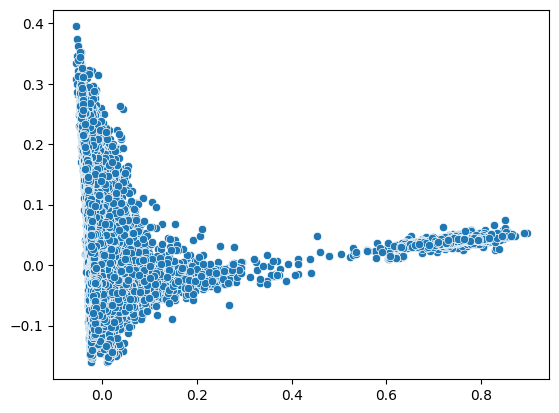

In [82]:
sns.scatterplot(x=X[:,0], y=X[:,1]);

não temos grupos bem definidos. Faz sentido não estar dando certo ate agora.

Tallvez uma tentativa usando o body

In [8]:
vectorizer = TfidfVectorizer(stop_words=pt_stopwords, max_features=1000)
X = vectorizer.fit_transform(df_itens_train['body'])

In [107]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

In [108]:
kmeans = KMeans(n_clusters=500, random_state=42)
pred = kmeans.fit_predict(X_pca)
silhouette_score(X_pca, pred)

np.float64(0.06582745426411792)

In [109]:
pca = PCA(n_components=25)
X_pca = pca.fit_transform(X)

In [110]:
kmeans = KMeans(n_clusters=250, random_state=42)
pred = kmeans.fit_predict(X_pca)
silhouette_score(X_pca, pred)

np.float64(0.09465527375433468)

In [111]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

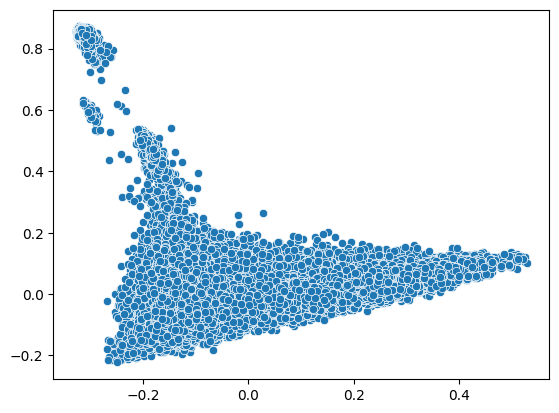

In [112]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1]);

In [6]:
from sklearn.cluster import DBSCAN

In [9]:
vectorizer = TfidfVectorizer(stop_words=pt_stopwords, max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(titulo_e_caption)
X.shape

(230043, 1000)

In [12]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
pred = dbscan.fit_predict(X)
silhouette_score(X, pred)

np.float64(-0.2608786486022192)

In [13]:
pca = PCA(n_components=250)
X_pca = pca.fit_transform(X)

In [14]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
pred = dbscan.fit_predict(X_pca)
silhouette_score(X_pca, pred)

np.float64(-0.12481318215949104)

In [15]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

In [20]:
try:
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    pred = dbscan.fit_predict(X_pca)
    silhouette_score(X_pca, pred)
except MemoryError:
    print('Sem memoria suficiente....')

Sem memoria suficiente....


In [10]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

In [11]:
try:
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    pred = dbscan.fit_predict(X_pca)
    silhouette_score(X_pca, pred)
except MemoryError:
    print('Sem memoria suficiente....')

: 

DBSCAN também não deu muito certo. Esse algoritmo está consumindo muita memória. Aparentemente a clusterização não está se mostando uma opção viável no momento. Vou analisar melhor outros dados.

A clusterização não tem se mostrado uma opção viável para busca de textos similares.

#### Testando o calculo de similaridade a partir da função cosine_similarity

Encontrei outra função para calcular a distancia entre 2 textos, vou testar essa nova função.

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
vectorizer = TfidfVectorizer(stop_words=pt_stopwords, max_features=5000)
X = vectorizer.fit_transform(titulo_e_caption)

In [9]:
try:
    similaridades = cosine_similarity(X)
except MemoryError as e:
    print('Sem memoria suficiente....')
    print(e)

Sem memoria suficiente....
Unable to allocate 391. GiB for an array with shape (52485569509,) and data type int64


In [32]:
from sklearn.utils.extmath import safe_sparse_dot
from tqdm import tqdm

def compute_similarity(tfidf_matrix, top_n=5):
    similarities = []
    for i in tqdm(range(tfidf_matrix.shape[0])):
        row_vector = tfidf_matrix[i]
        sim_scores = safe_sparse_dot(row_vector, tfidf_matrix.T, dense_output=True)
        top_indices = sim_scores.argsort()[-top_n:][::-1]
        similarities.append((i, top_indices))
    return similarities

In [20]:
try:
    similaridades = compute_similarity(X, top_n=10)
except MemoryError as e:
    print('Sem memoria suficiente....')
    print(e)

  0%|          | 0/230043 [00:00<?, ?it/s]

  3%|▎         | 6744/230043 [59:33<32:52:13,  1.89it/s]    


Sem memoria suficiente....
Unable to allocate 75.0 MiB for an array with shape (19661707,) and data type int32


A quantidade de itens é muito grande, mas talvez a gente não tenha que se preocupar com as matérias mais antigas em um primeiro momento....

In [8]:
# 2 semanas antes do ultimo item
filtro_data = pd.to_datetime(df_itens_test['issued'].max()) - pd.Timedelta(days=14)
filtro_data

Timestamp('2022-08-01 02:57:16+0000', tz='UTC')

In [20]:
vectorizer = TfidfVectorizer(stop_words=pt_stopwords, max_features=250, ngram_range=(1, 2), min_df=0.2, max_df=0.8)
vectorizer.fit(df_itens_train['body'])

TfidfVectorizer(max_df=0.8, max_features=250, min_df=0.2, ngram_range=(1, 2),
                stop_words=['a', 'à', 'ao', 'aos', 'aquela', 'aquelas',
                            'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até',
                            'com', 'como', 'da', 'das', 'de', 'dela', 'delas',
                            'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é',
                            'ela', 'elas', 'ele', 'eles', ...])

In [21]:
', '.join(vectorizer.get_feature_names_out())

'10, acordo, ainda, além, ano, anos, antes, após, brasil, casa, caso, cidade, civil, conta, contra, desde, desta, dia, dias, disse, divulgação, diz, dois, duas, durante, estado, fazer, federal, feira, g1, grande, informou, local, maior, meio, mil, momento, nesta, notícias, onde, outras, outros, parte, paulo, pessoas, pode, polícia, porque, público, região, reprodução, rio, saúde, segunda, segundo, sendo, sexta, sobre, ter, todo, todos, três, tv, vai, veja, veja notícias, vídeos'

In [22]:
itens_filtrado = df_itens_test[pd.to_datetime(df_itens_test['issued']) >= filtro_data]
X = vectorizer.transform(itens_filtrado['body'])


In [36]:
try:
    similaridades = compute_similarity(X)
except MemoryError as e:
    print('Sem memoria suficiente....')
    print(e)

100%|██████████| 1081/1081 [00:00<00:00, 1350.28it/s]


In [37]:
similaridades[:3]

[(0, array([[595, 117, 325, ..., 249, 556,   0]], shape=(1, 1081))),
 (1, array([[1065,  117,  595, ...,  620,  431,    1]], shape=(1, 1081))),
 (2, array([[1050, 1065,  414, ...,  567,  548,    2]], shape=(1, 1081)))]

In [38]:
def print_similaridades(similaridades, itens_filtrado):
    for i in range(3):
        for j in range(1, 5):
            print(itens_filtrado.iloc[similaridades[i][1][0][-j]]['title'], ' -- ', itens_filtrado.iloc[similaridades[1][1][0][i]]['caption'])
            print('-----------------------------------')
        
        print('\n\n')

print_similaridades(similaridades, itens_filtrado)

Maceió começa a vacinar contra Covid crianças de 4 anos sem comorbidades  --  Interessados devem se inscrever  na secretaria da escola até o dia 15 de agosto.
-----------------------------------
Campanhas de vacinação contra pólio e multivacinação começam na segunda-feira em Alagoas   --  Interessados devem se inscrever  na secretaria da escola até o dia 15 de agosto.
-----------------------------------
Mogi das Cruzes abre novos agendamentos para vacinação contra Covid-19, nesta quarta-feira  --  Interessados devem se inscrever  na secretaria da escola até o dia 15 de agosto.
-----------------------------------
Cuiabá irá retomar vacinação da BCG em crianças; veja locais   --  Interessados devem se inscrever  na secretaria da escola até o dia 15 de agosto.
-----------------------------------



Adolescente filha de vítima de feminicídio é morta a tiros no ES e ex-namorado é preso suspeito do crime   --  No total foram analisados 66 itens, entre frutas, verduras, legumes e temperos. 
-

A combinação entre `TfidfVectorizer` para extração de tokens e o calculo de similaridades feito pela função `compute_similarity` está retornando resultados interessantes.

Acredito que o resultado atual pode ser aproveitado para a implementação do sistema de recomendação de noticias desse datathon.

### Criando a matriz de similaridades entre os textos

Primeiramente precisamos do modelo de vetorização que vamos usar para o sistema de recomendações

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

import pandas as pd

import pickle
import nltk
import os

In [2]:
def obter_stopwords(linguagem:str):
    nltk.download('stopwords', quiet=True)
    return list(stopwords.words(linguagem))

def treinar_vectorizer(textos:pd.Series, linguagem='portuguese', max_features=500, ngram_range=(1, 2), min_df=0.2, max_df=0.8):
    stopwords = obter_stopwords(linguagem)
    vectorizer = TfidfVectorizer(
        stop_words=stopwords, 
        max_features=max_features, 
        ngram_range=ngram_range, 
        min_df=min_df, 
        max_df=max_df
    )
    vectorizer.fit(textos)
    return vectorizer

def treinar_e_salvar_vectorizer(textos: pd.Series):
    os.makedirs('models', exist_ok=True)

    vectorizer = treinar_vectorizer(textos)

    with open(r'models/vectorizer_body.pkl', 'wb') as file:
        pickle.dump(vectorizer, file)
    
    return vectorizer

def carregar_vectorizer():
    with open(r'models/vectorizer_body.pkl', 'rb') as file:
        return pickle.load(file)
    
def carregar_ou_treinar_vectorizer(forcar_treino=False):
    if not forcar_treino and os.path.exists(r'models/vectorizer_body.pkl'):
        return carregar_vectorizer()
    else:
        textos = carregar_textos_recentes()
        return treinar_e_salvar_vectorizer(textos=textos['body'])
    
def carregar_textos_recentes(dias=14):
    df = pd.read_csv(r'data/itens/itens/long_format.csv')
    filtro_data = pd.to_datetime(df['issued'].max()) - pd.Timedelta(days=dias)
    return df[pd.to_datetime(df['issued']) >= filtro_data]

In [3]:
vectorizer = carregar_ou_treinar_vectorizer()

In [23]:
def obter_similaridades(textos:pd.Series, vectorizer:TfidfVectorizer, n_top=5):
    X = vectorizer.transform(textos)
    similaridades = cosine_similarity(X)
    return [ (it[-1], list(reversed(it[-n_top-1:-1]))) for it in similaridades.argsort() ]

In [24]:
materias = carregar_textos_recentes()
similaridades = obter_similaridades(materias['body'], vectorizer)

In [25]:
similaridades[0]

(np.int64(0),
 [np.int64(1260),
  np.int64(4870),
  np.int64(9849),
  np.int64(3138),
  np.int64(887)])

In [26]:
def print_similaridades(similaridades, textos):
    for base, sugestoes in similaridades:
        print(textos.iloc[base]['title'])
        for sugestao in sugestoes:
            print('--------------------------------------')
            print('  ', textos.iloc[sugestao]['title'])
        print('\n\n')

In [27]:
print_similaridades(similaridades[:3], materias)

Saúde descarta varíola dos macacos em dois imigrantes que passaram por exames no AC 
--------------------------------------
   Criança de 6 anos dá entrada em UPA de Rio Branco com suspeita de varíola dos macacos
--------------------------------------
   Jundiaí registra mais dois casos de varíola dos macacos
--------------------------------------
   Estado confirma primeiro caso de varíola dos macacos em Jarinu
--------------------------------------
   Sandy propaga levezas com Agnes Nunes e Wanessa Camargo no primeiro single do EP 'Nós, Voz, Eles 2'
--------------------------------------
   Acre investiga cinco casos suspeitos de varíola dos macacos e tem uma confirmação da doença 



Sine Acre oferece 37 vagas de emprego nesta terça-feira (2) ; confira a lista
--------------------------------------
   Sine Acre oferece 47 vagas de emprego nesta quinta-feira (4); confira a lista
--------------------------------------
   Sine Acre oferece 45 vagas de emprego nesta quarta-feira (3); co

A qualidade das sugestões está bem legal e aproveitavel. Podemos seguir em frente com as sugestões obtidas a partir desse código.

Vou salvar o resultado desse código para utilizações posteriores.

In [34]:
def converter_em_ids_das_materias(sugestoes, materias):
    resultado = []
    for base, similares in sugestoes:
        linha = [
            materias.iloc[base]['page'],
            *[ materias.iloc[i]['page'] for i in similares ]
        ]
        resultado.append(linha)
    return pd.DataFrame(resultado, columns=['base', 'sugestao1', 'sugestao2', 'sugestao3', 'sugestao4', 'sugestao5'])

In [37]:
df_sugestoes = converter_em_ids_das_materias(similaridades, materias)
df_sugestoes.head(3)

,base,sugestao1,sugestao2,sugestao3,sugestao4,sugestao5
0,790f8f6d-2674-462d-ab94-47239c2f60d5,531a8b77-e546-400a-ab9e-f05c5b8c2dfc,5e7b1c29-49c1-43a3-bf17-01f18e63a6c3,5b381dbc-b364-48e4-861c-816cb043b30f,552b9004-5ac4-44c2-8edb-84232e3bfe4c,6cd71ce6-9d26-480c-b6f8-e7268e1dc8c2
1,edc93569-bf37-437d-a6c3-fda029f8bc70,5a301c99-f2cd-4af7-9dca-3a5497651191,9eddd003-a771-499a-ae3c-d3874d12a379,4eda2c3c-5947-4ff4-a514-03cc8472bb5c,6af5a619-d862-4b05-8c99-e7a4ba66754c,047d0f21-8f2b-4c14-89e8-0efb2662287e
2,d458eb60-018c-42d1-9731-7d65be3ada78,3395c0ad-e244-4592-8a17-87fe469b05d1,2ffb7eca-ae76-4f39-9957-ec25418ebaf6,5bc2e357-a3c5-41a3-9ea1-bbb2b54a056c,ceb7c1ae-f0da-422b-a697-caa3a71d4dd0,6d518d03-adbe-4cad-a7b6-28ec8d88adba


In [38]:
df_sugestoes.to_csv(r'data/sugestoes.csv', index=False)

Agora eu tenho um dataframe com as recomendações de materias similares para utilização em analises futuras!

### Análise do dataframe de atividade dos usuários

In [7]:
df_treino_train.head(1)

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory
2706609,3af3dd1335a8bcd0a92d7ede0b077a28ec6edb2953494f...,Logged,376,5ad189e3-77e6-4c5e-9eed-8979ba58e283,2022-08-10 23:36:45.519,21,54004,35.24,2


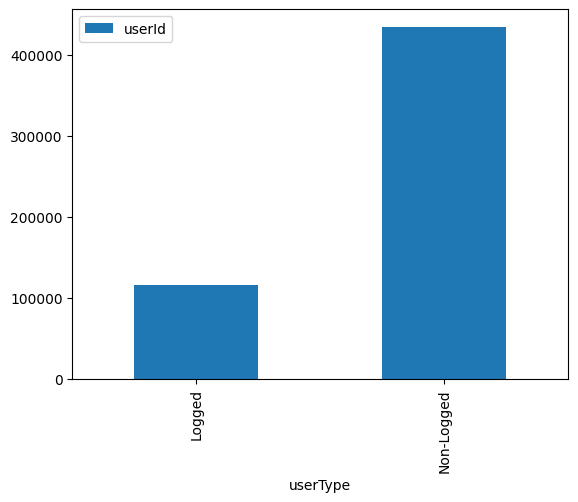

In [14]:
df_treino_train[['userId', 'userType']].drop_duplicates().groupby('userType').count().plot(kind='bar');

O dataset esta muito desbalanceado, mas é esperado que tenha mais usuários deslogados que usuários logados.

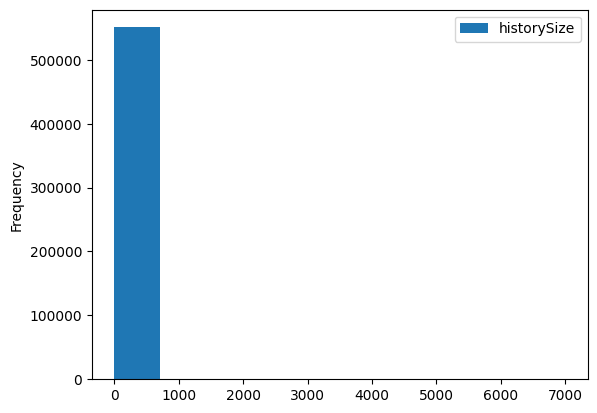

In [51]:
df_treino_train[['userId', 'userType', 'historySize']].drop_duplicates().drop('userId', axis=1).plot(kind='hist');

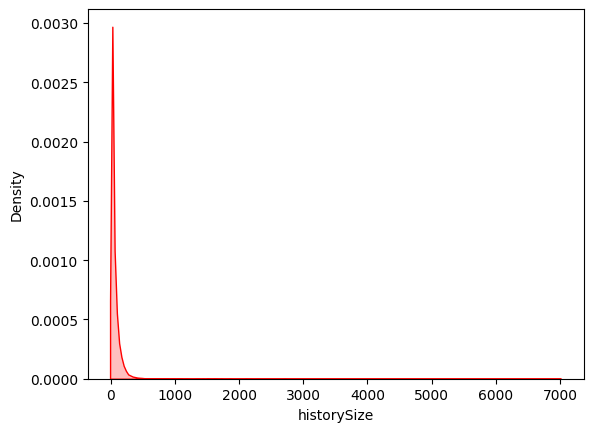

In [68]:
sns.kdeplot(df_treino_train[['userId', 'userType', 'historySize']].drop_duplicates()['historySize'], fill=True, color='red');

Usando o KDE, podemos ver que tem uma grande concentração de usuarios que lêem menos que 1000 matérias, mas uma quantidade quase constante de usuários que leram mais de 1000.

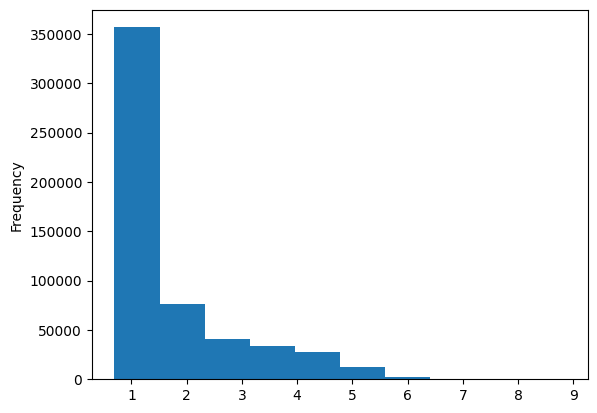

In [73]:
np.log1p(df_treino_train[['userId', 'userType', 'historySize']].drop_duplicates()['historySize']).plot(kind='hist');

Usando uma escala logaritmica, podemos reduzir a distorção do gráfico e ter uma noção melhor da distribuição dos dados. Essa informação pode ajudar a traçar um perfil dos usuários, ajudando a separar usuários frequentes dos usuários ocasionais. 

In [49]:
len(df_treino_train), len(df_treino_train[df_treino_train['historySize'] < 20])

(7311556, 1319078)

Por mais que a distribuição de usuários que leram mais de 20 matérias seja mais distribuida a maior parte dos usuários ficam acima dessa faixa de acessos. Essa distribuição está dificulando a analise da distribuição dos dados.

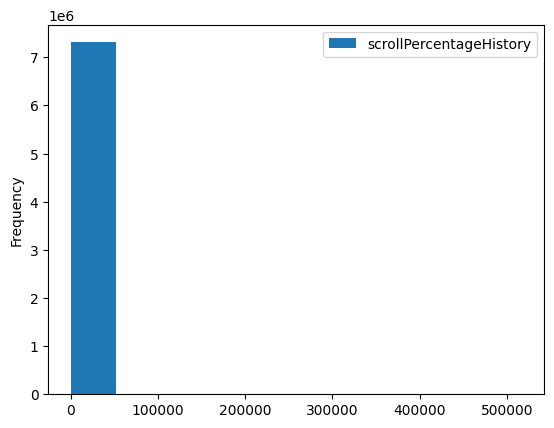

In [79]:
df_treino_train[['scrollPercentageHistory']].plot(kind='hist');

In [80]:
print(len(df_treino_train), len(df_treino_train[df_treino_train['scrollPercentageHistory'] > 100.0]))

7311556 1993


é muito estranho que exista casos em que a porcentagem de scroll seja maior que 100%. Acredito que esses casos podem estar relacionados a bugs na ferramenta que captura essas métricas.

In [81]:
df_treino_train.loc[df_treino_train['scrollPercentageHistory'] > 100.0, 'scrollPercentageHistory'] = 100.0

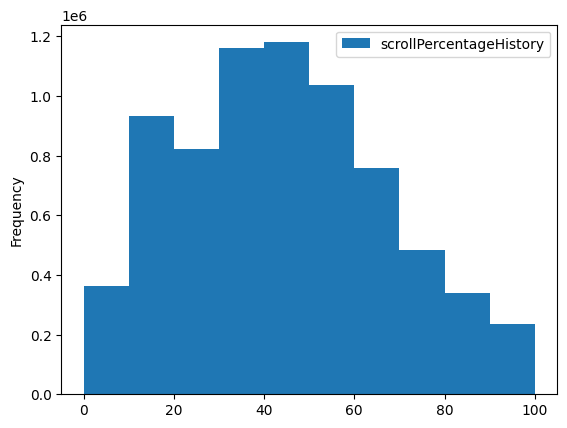

In [82]:
df_treino_train[['scrollPercentageHistory']].plot(kind='hist');

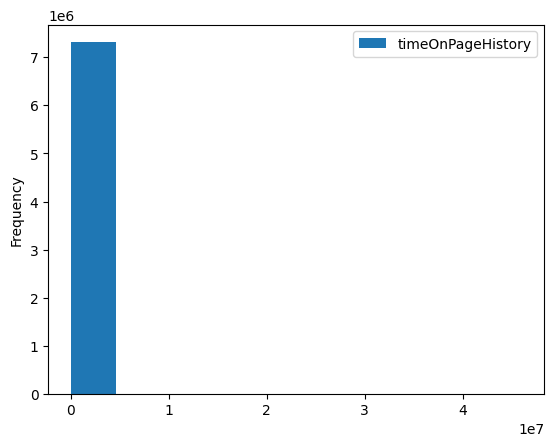

In [83]:
df_treino_train[['timeOnPageHistory']].plot(kind='hist');

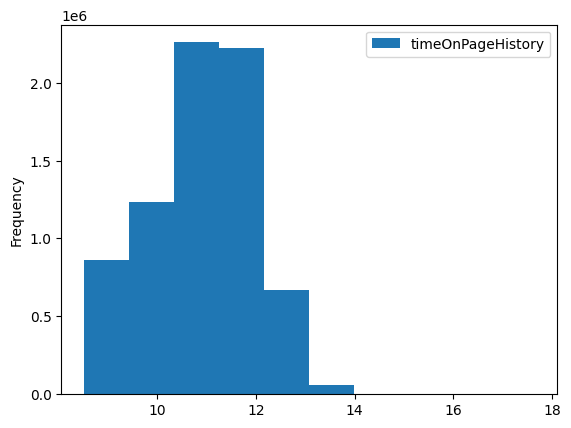

In [84]:
np.log1p(df_treino_train[['timeOnPageHistory']]).plot(kind='hist');

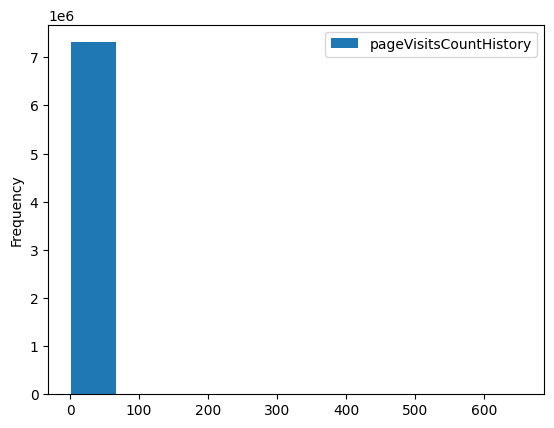

In [85]:
df_treino_train[['pageVisitsCountHistory']].plot(kind='hist');

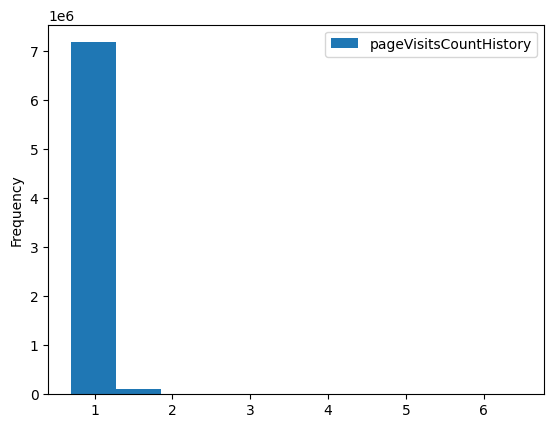

In [86]:
np.log1p(df_treino_train[['pageVisitsCountHistory']]).plot(kind='hist');

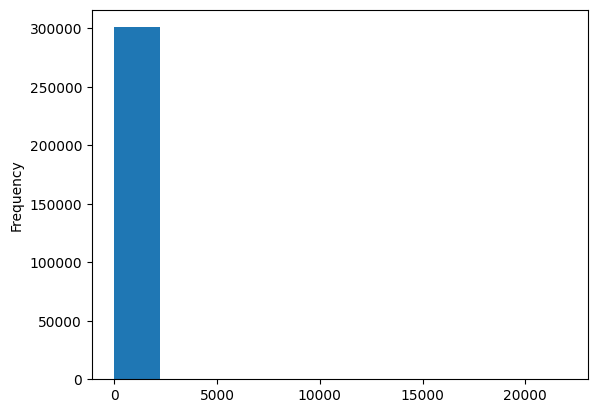

In [90]:
df_treino_train['history'].value_counts().plot(kind='hist');

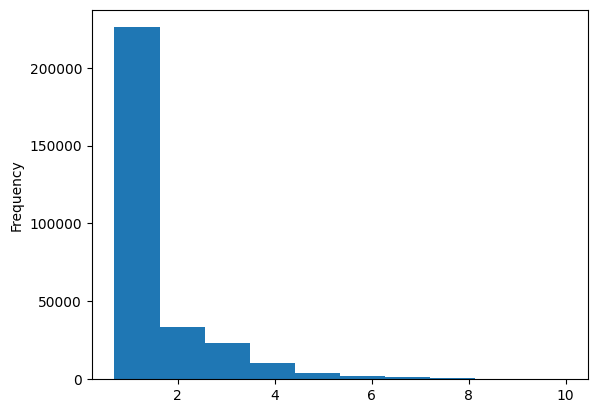

In [91]:
np.log1p(df_treino_train['history'].value_counts()).plot(kind='hist');

In [92]:
df_treino_train['history'].value_counts().sort_values(ascending=False).head(10)

history
d2593c3d-2347-40d9-948c-b6065e8459a9    21950
f6b5d170-48b9-4f8e-88d4-c84b6668f3bd    19613
1f32787b-de2b-49be-8c20-ddaeae34cc22    16534
f0a78e58-ec7e-494c-9462-fbd6446a9a89    16119
6a83890a-d9e9-4f6b-a6c6-90d031785bbf    15966
855d20b7-53f2-4678-a10f-55402d085018    15328
4c63d7cd-4902-4ffb-9b94-578b1b2151f0    15075
1c27cf97-b20c-4e40-b1f1-288b721517b3    14609
bf257382-74fb-4392-ad6a-143240e39f81    13344
a36c98b5-f159-48f8-9f5a-1fc6ea9956c8    13288
Name: count, dtype: int64

In [93]:
df_treino_train['history'].value_counts().sort_values().head(10)

history
 486ba81a-8f76-49d3-836e-bca5e109272e    1
 d1672ec7-3c13-4571-a993-bb22691a192e    1
 802da87e-676b-421e-9d41-2fcbb5ce4b28    1
 3fc1cd94-b290-4456-b600-dbf8f5fac88e    1
 31865ff6-594b-4ae1-bc6e-6339fbf44f6e    1
efd324d1-9e31-4653-9da6-4cfe86f26993     1
 e0b7ff1c-54ed-4345-8292-9f6918eb48b5    1
4bd197cd-0d04-42a4-94eb-aad091d7bfc9     1
49435b8a-f34e-471b-9c28-14e21413c148     1
0c02336c-cbff-4aaf-aa1b-3017c56e0a47     1
Name: count, dtype: int64

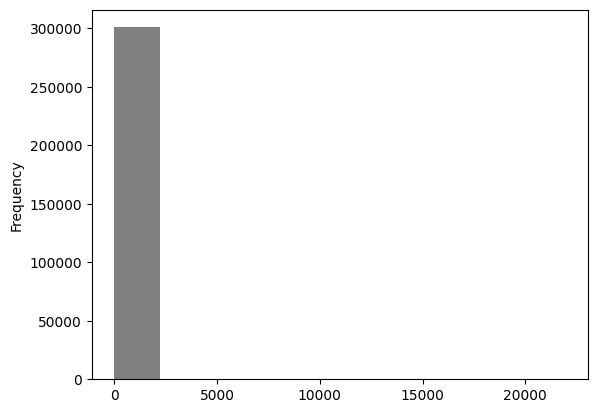

In [11]:
df_treino_train.groupby('history').count().plot(kind='hist', legend=False);

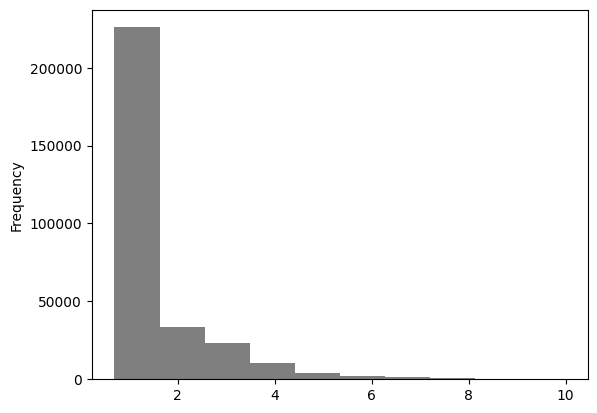

In [12]:
np.log1p(df_treino_train.groupby('history').count()).plot(kind='hist', legend=False);

In [17]:
np.log1p(df_treino_train.groupby('history').count())['userId'].sort_values(ascending=False).head(10)

history
d2593c3d-2347-40d9-948c-b6065e8459a9    9.996568
f6b5d170-48b9-4f8e-88d4-c84b6668f3bd    9.883999
1f32787b-de2b-49be-8c20-ddaeae34cc22    9.713235
f0a78e58-ec7e-494c-9462-fbd6446a9a89    9.687816
6a83890a-d9e9-4f6b-a6c6-90d031785bbf    9.678279
855d20b7-53f2-4678-a10f-55402d085018    9.637502
4c63d7cd-4902-4ffb-9b94-578b1b2151f0    9.620859
1c27cf97-b20c-4e40-b1f1-288b721517b3    9.589462
bf257382-74fb-4392-ad6a-143240e39f81    9.498897
a36c98b5-f159-48f8-9f5a-1fc6ea9956c8    9.494692
Name: userId, dtype: float64

In [18]:
df_treino_train.groupby('history').count()['userId'].sort_values(ascending=False).head(10)

history
d2593c3d-2347-40d9-948c-b6065e8459a9    21950
f6b5d170-48b9-4f8e-88d4-c84b6668f3bd    19613
1f32787b-de2b-49be-8c20-ddaeae34cc22    16534
f0a78e58-ec7e-494c-9462-fbd6446a9a89    16119
6a83890a-d9e9-4f6b-a6c6-90d031785bbf    15966
855d20b7-53f2-4678-a10f-55402d085018    15328
4c63d7cd-4902-4ffb-9b94-578b1b2151f0    15075
1c27cf97-b20c-4e40-b1f1-288b721517b3    14609
bf257382-74fb-4392-ad6a-143240e39f81    13344
a36c98b5-f159-48f8-9f5a-1fc6ea9956c8    13288
Name: userId, dtype: int64

In [20]:
df_treino_train.groupby('history').count()['userId'].median()

np.float64(1.0)

In [25]:
df_treino_train.groupby('history').count()['userId'].quantile([0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99])

0.25      1.0
0.50      1.0
0.75      5.0
0.80      7.0
0.90     18.0
0.95     40.0
0.99    369.0
Name: userId, dtype: float64

O resultado desses percentiles, fica bem claro que a maior parte das notícias não são muito acessadas. Existe ainda a possibilidade de que existam textos que nunca foram acessados por nenhum usuário.